# Homework 5.2

Use the [Gowalla dataset](https://snap.stanford.edu/data/loc-gowalla.html) to estimate the overall popularity (i.e., number of visits) of each location in the dataset
* Plot the distribution of the locations’ popularity. What’s the shape of the distribution? Comment on it.
* Compute (using skmob) the uncorrelated location entropy of each location, plot its distribution.
* Show is there is a correlation between popularity and location entropy: Are more popular locations also the most “entropic” ones? Provide your interpretation of the result you get
* Repeat for the [Brightkite dataset](https://snap.stanford.edu/data/loc-brightkite.html)
* Submit a well-commented notebook

## Installing the libraries

In [1]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.3 MB/s 
     |███████████████

## Importing the libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import skmob
from skmob.utils.plot import plot_gdf
import folium
from folium.plugins import HeatMap
import random

import urllib.request
import requests

from shapely.geometry import *

#to compute the entropy and the visits
from skmob.measures import collective

# Gowalla Dataset

## Downloading the dataset

In [3]:
url = 'https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz'
file_name = url[url.rfind('/')+1:]
urllib.request.urlretrieve(url, file_name)

('loc-gowalla_totalCheckins.txt.gz',
 <http.client.HTTPMessage at 0x1c479bb6100>)

In [4]:
df = pd.read_csv(file_name, 
                 names = ['user', 'check_in_time', 'lat', 'lng', 'location_id'],
                 compression = 'gzip', 
                 delimiter = '\t', 
                 header = None)

In [5]:
len(df)

6442892

In [6]:
df.isna().sum()

user             0
check_in_time    0
lat              0
lng              0
location_id      0
dtype: int64

## Visualizing a sample of the dataset
The dataset is too big for my computer to manage

In [7]:
sampled_df = df.sample(frac=0.05)
sample_heat_data = list(zip(sampled_df['lat'].values, sampled_df['lng'].values))

In [60]:
map_f = folium.Map(location=(0.0, 0.0), zoom_start = 2)
HeatMap(sample_heat_data).add_to(map_f)
#map_f

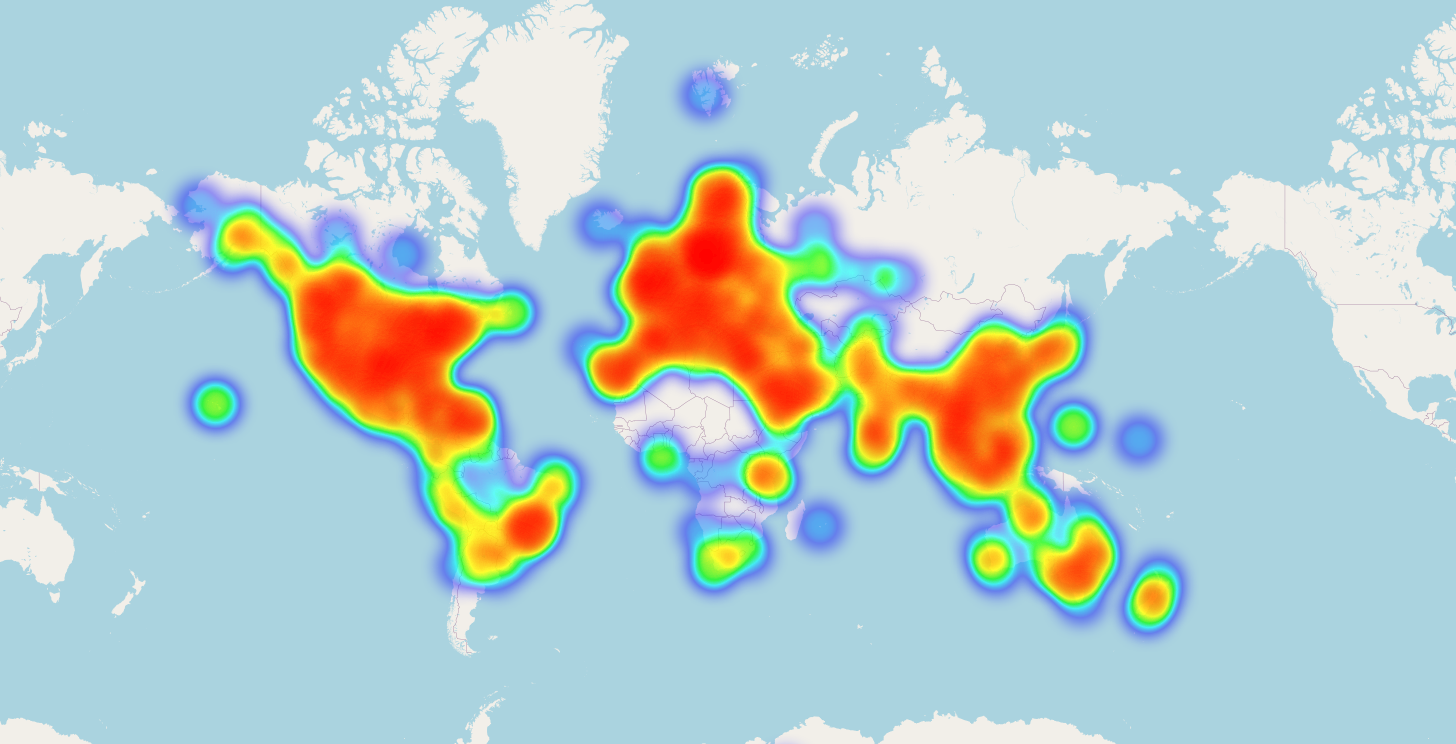

## Getting the trajectory data frame

In [9]:
#converting the df into a trajectory dataframe
tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lng', datetime='check_in_time', user_id='user')
#sorting according to user and date time
tdf = tdf.sort_values(by=['uid', 'datetime']).reset_index(drop=True)

## Getting the most popular locations

Using the location ID

In [10]:
#adding a unit count for each record
df['count'] = [1]*len(df)
#grouping the locations to get the count of checkins
grouped_locations = df[['location_id', 'count']].groupby('location_id').agg(sum)
#sorting by most popular locations
by_popularity = grouped_locations.sort_values('count', ascending=False).reset_index()
#extracting the locations with more than 100 checkins
more_hund_checkins = by_popularity[by_popularity['count'] > 100]['location_id'].values
popular_records = df[df['location_id'].isin(more_hund_checkins)]

In [11]:
by_popularity.head()

,location_id,count
0,55033,5811
1,19542,5662
2,9410,4713
3,10259,4083
4,58725,3476


Using the skmob library

In [12]:
by_popularity = collective.visits_per_location(tdf)
by_popularity.head()

,lat,lng,n_visits
0,59.330158,18.058079,5811
1,37.616356,-122.386150,5662
2,30.263515,-97.740169,4765
3,30.201557,-97.667127,4718
4,32.897462,-97.040348,4084


In [13]:
#extracting the locations with more than 100 checkins
more_hund_checkins = by_popularity[by_popularity['n_visits'] > 100]
popular_records = more_hund_checkins

## Visualizing a heatmap of the most popular locations

In [14]:
heat_data = list(zip(popular_records['lat'], popular_records['lng']))

In [61]:
map_f = folium.Map(location=(0.0, 0.0), zoom_start = 2)
HeatMap(heat_data).add_to(map_f)
#map_f

## Plotting the popularity distribution of locations
As it can be seen the shape of the distribution is a heavy tailed, it follows a power law. Some locations, mostly in Europe, US, the arabian gulf and south-east asia are the most visited places

In [16]:
by_popularity.head()

,lat,lng,n_visits
0,59.330158,18.058079,5811
1,37.616356,-122.386150,5662
2,30.263515,-97.740169,4765
3,30.201557,-97.667127,4718
4,32.897462,-97.040348,4084


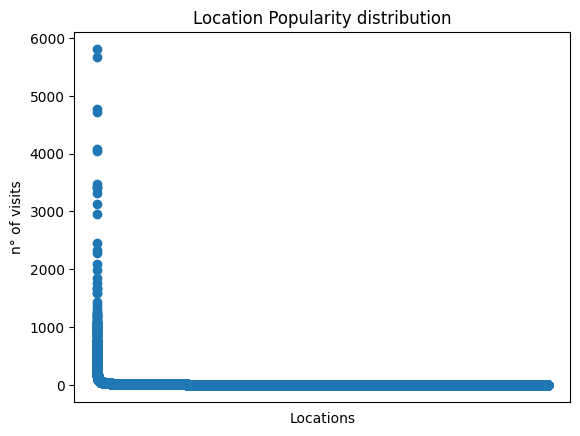

In [17]:
plt.scatter(by_popularity.index, by_popularity['n_visits'])
plt.title('Location Popularity distribution')
plt.xticks([])
plt.xlabel('Locations')
plt.ylabel('n° of visits')
plt.show()

Some locations are visited only once or two times in comparison with thousand, thus the stair shape at the end of the normalized distribution

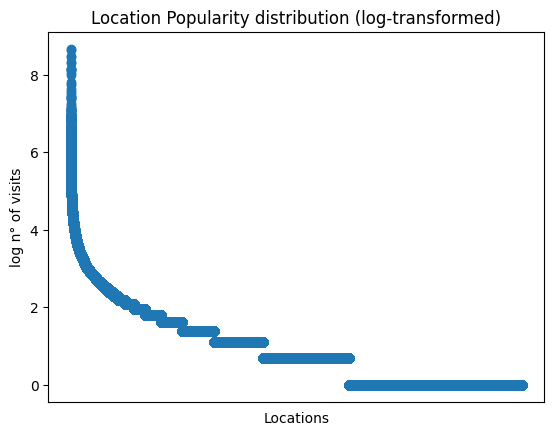

In [18]:
plt.scatter(by_popularity.index, np.log(by_popularity['n_visits'].values))
plt.title('Location Popularity distribution (log-transformed)')
plt.xticks([])
plt.xlabel('Locations')
plt.ylabel('log n° of visits')
plt.show()

## Computing entropy

In [19]:
entropy = collective.uncorrelated_location_entropy(tdf, normalize=False, show_progress=True)

100%|██████████████████████████████████████████████████████████████████████| 1256693/1256693 [17:41<00:00, 1183.68it/s]


In [20]:
entropy.head()

,lat,lng,uncorrelated_location_entropy
0,-90.000000,-139.266667,0.0
1,-90.000000,0.001459,0.0
2,-89.994287,-0.050530,0.0
3,-72.883397,43.423462,0.0
4,-65.718205,99.826584,0.0


In [21]:
entropy[entropy['uncorrelated_location_entropy'] != 0.0].head()

,lat,lng,uncorrelated_location_entropy
10,-45.925006,170.200539,0.500402
11,-45.912696,170.488005,0.950271
20,-45.878718,170.501021,0.636514
32,-45.874027,170.503810,0.562335
87,-45.037223,168.649763,0.693147


In [22]:
locations_bylatlng = pd.DataFrame([[x] for x in list(zip(tdf['lat'], tdf['lng']))])[0].unique()
assert len(locations_bylatlng) == len(entropy), 'The records of locations should be the same'

## Plotting the distribution of Entropy
Even in this case we have a power law as the distribution is skewed towards a small number of locations with high entropy and a small number of them with lower entropy

In [23]:
sorted_entropy = entropy.sort_values(by='uncorrelated_location_entropy', ascending=False).reset_index(drop=True)

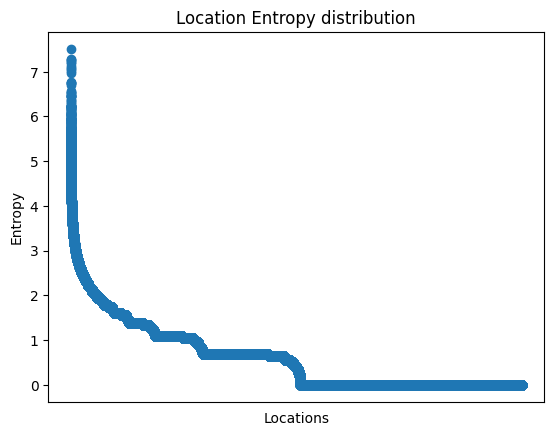

In [24]:
plt.scatter(sorted_entropy.index, sorted_entropy['uncorrelated_location_entropy'])
plt.title('Location Entropy distribution')
plt.xticks([])
plt.xlabel('Locations')
plt.ylabel('Entropy')
plt.show()

The warning is just because I have some zeroes in the distribution and for those the log is not defined

C:\Users\Ludovico\AppData\Local\Temp\ipykernel_10452\1203736129.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(sorted_entropy.index, np.log(sorted_entropy['uncorrelated_location_entropy'].values))


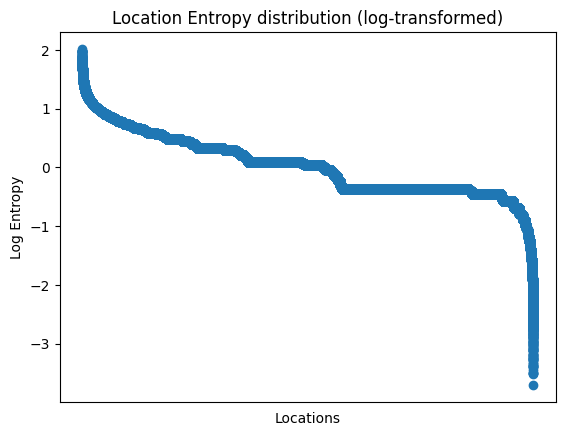

In [25]:
plt.scatter(sorted_entropy.index, np.log(sorted_entropy['uncorrelated_location_entropy'].values))
plt.title('Location Entropy distribution (log-transformed)')
plt.xticks([])
plt.xlabel('Locations')
plt.ylabel('Log Entropy')
plt.show()

## Computing the correlation between Location popularity and Entropy
The spearman correlation is around 0.80, thus the entropy and the popularity of places are positively correlated (the more a place is popular, the higher the entropy)

In [26]:
popularity_entropy = by_popularity.merge(entropy, on=['lat', 'lng'])[['n_visits', 'uncorrelated_location_entropy']]
popularity_entropy.head()

,n_visits,uncorrelated_location_entropy
0,5811,7.226905
1,5662,7.513843
2,4765,5.934476
3,4718,7.290359
4,4084,7.252851


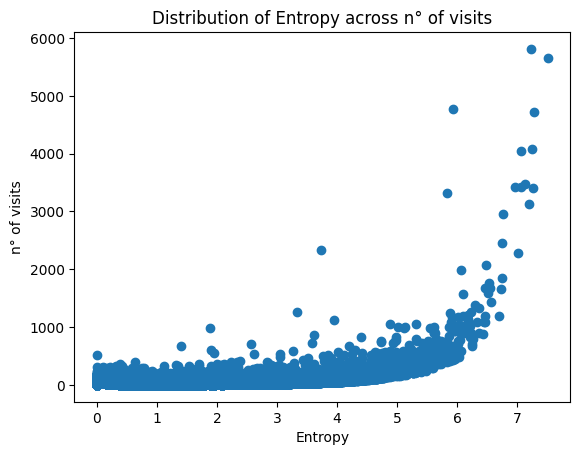

In [27]:
plt.scatter(popularity_entropy['uncorrelated_location_entropy'], popularity_entropy['n_visits'])
plt.title('Distribution of Entropy across n° of visits')
plt.xlabel('Entropy')
plt.ylabel('n° of visits')
plt.show()

With spearman (as pearson requires a normal distribution of the two features)

In [28]:
popularity_entropy.corr(method='spearman')

,n_visits,uncorrelated_location_entropy
n_visits,1.00000,0.79359
uncorrelated_location_entropy,0.79359,1.00000


Just checking what pearson would have returned

In [29]:
popularity_entropy.corr()

,n_visits,uncorrelated_location_entropy
n_visits,1.000000,0.345358
uncorrelated_location_entropy,0.345358,1.000000


I think that it is rather unlikely that a model could correctly predict the next location of a user in this dataset if the location in question is popular among the other users, because the pattern that leads to the choice of that location is not evident by itself from the trajectory of the user. </br></br> <b>It could be that popular places are a common destination of a lot of users but they are not intrinsically connected to the previous locations.</b></br>

# Brightkite dataset

## Downloading the dataset

In [30]:
url = 'https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz'
file_name = url[url.rfind('/')+1:]
urllib.request.urlretrieve(url, file_name)

('loc-brightkite_totalCheckins.txt.gz',
 <http.client.HTTPMessage at 0x1c4edf1b580>)

In [31]:
df = pd.read_csv(file_name, 
                 names = ['user', 'check_in_time', 'lat', 'lng', 'location_id'],
                 compression = 'gzip', 
                 delimiter = '\t', 
                 header = None)

In [32]:
len(df)

4747287

In [33]:
df.isna().sum()

user             0
check_in_time    6
lat              6
lng              6
location_id      6
dtype: int64

In [34]:
df = df.dropna()

## Visualizing a sample of the dataset
The dataset is too big for my computer to manage

In [35]:
sampled_df = df.sample(frac=0.05)
sample_heat_data = list(zip(sampled_df['lat'].values, sampled_df['lng'].values))

In [62]:
map_f = folium.Map(location=(0.0, 0.0), zoom_start = 2)
HeatMap(sample_heat_data).add_to(map_f)
#map_f

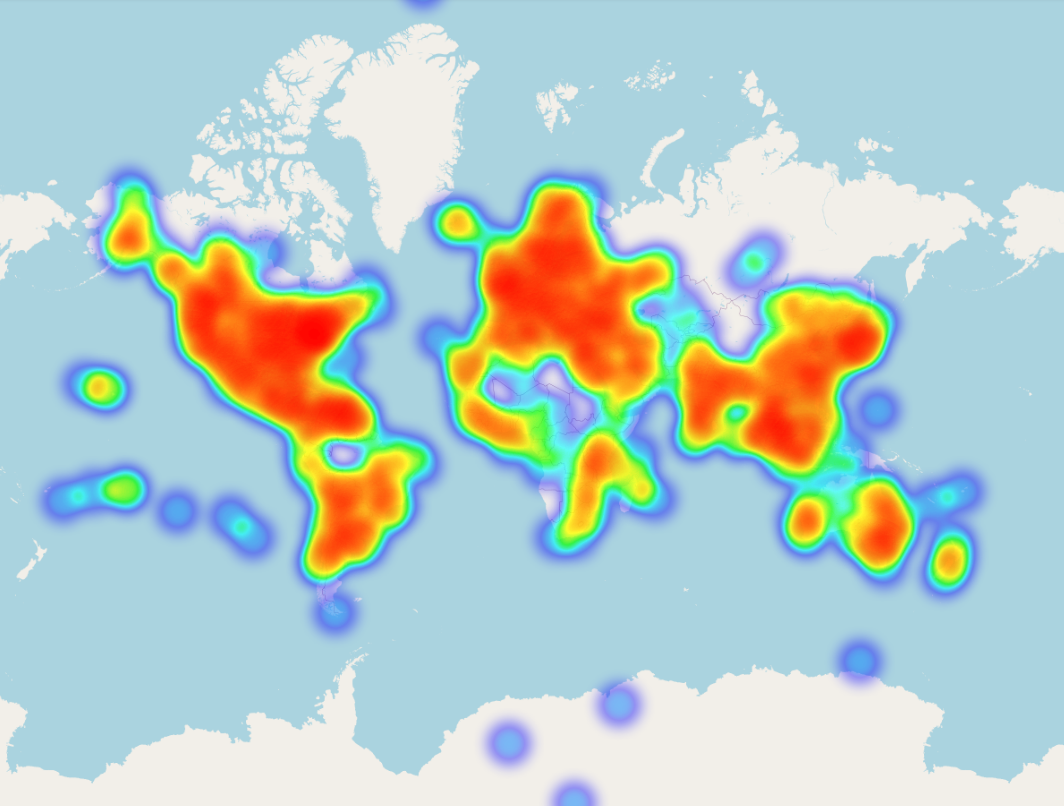

## Getting the trajectory data frame

In [37]:
#converting the df into a trajectory dataframe
tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lng', datetime='check_in_time', user_id='user')
#sorting according to user and date time
tdf = tdf.sort_values(by=['uid', 'datetime']).reset_index(drop=True)

## Getting the most popular locations

Using the location ID

In [38]:
#adding a unit count for each record
df['count'] = [1]*len(df)
#grouping the locations to get the count of checkins
grouped_locations = df[['location_id', 'count']].groupby('location_id').agg(sum)
#sorting by most popular locations
by_popularity = grouped_locations.sort_values('count', ascending=False).reset_index()
#extracting the locations with more than 100 checkins
more_hund_checkins = by_popularity[by_popularity['count'] > 100]['location_id'].values
popular_records = df[df['location_id'].isin(more_hund_checkins)]

In [39]:
by_popularity.head()

,location_id,count
0,00000000000000000000000000000000,254619
1,ee81ef22a22411ddb5e97f082c799f59,17396
2,ede07eeea22411dda0ef53e233ec57ca,16896
3,ee8b1d0ea22411ddb074dbd65f1665cf,16687
4,ee78cc1ca22411dd9b3d576115a846a7,14487


Using the skmob library

In [40]:
by_popularity = collective.visits_per_location(tdf)
by_popularity.head()

,lat,lng,n_visits
0,0.000000,0.000000,256137
1,37.774929,-122.419415,17396
2,40.714269,-74.005973,16908
3,39.739154,-104.984703,16687
4,34.052234,-118.243685,15445


In [41]:
#extracting the locations with more than 100 checkins
more_hund_checkins = by_popularity[by_popularity['n_visits'] > 100]
popular_records = more_hund_checkins

In [42]:
len(popular_records)

5258

## Visualizing a heatmap of the most popular locations

In [43]:
heat_data = list(zip(popular_records['lat'], popular_records['lng']))

In [63]:
map_f = folium.Map(location=(0.0, 0.0), zoom_start = 2)
HeatMap(heat_data).add_to(map_f)
#map_f

## Plotting the popularity distribution of locations
As it can be seen the shape of the distribution is a heavy tailed, it follows a power law. Some locations, mostly in Europe, US, the arabian gulf and south-east asia are the most visited places

In [45]:
by_popularity.head()

,lat,lng,n_visits
0,0.000000,0.000000,256137
1,37.774929,-122.419415,17396
2,40.714269,-74.005973,16908
3,39.739154,-104.984703,16687
4,34.052234,-118.243685,15445


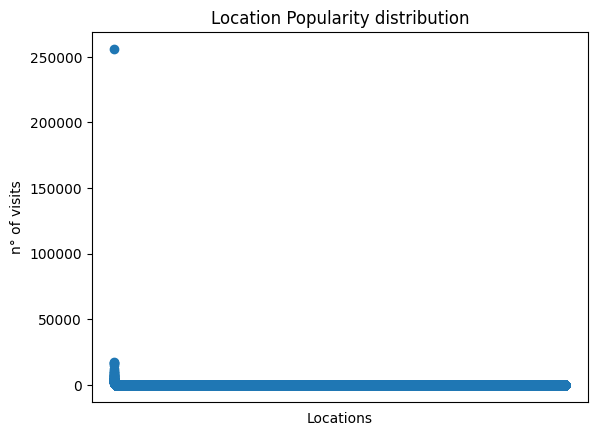

In [46]:
plt.scatter(by_popularity.index, by_popularity['n_visits'])
plt.title('Location Popularity distribution')
plt.xticks([])
plt.xlabel('Locations')
plt.ylabel('n° of visits')
plt.show()

Some locations are visited only once or two times in comparison with thousand, thus the stair shape at the end of the normalized distribution

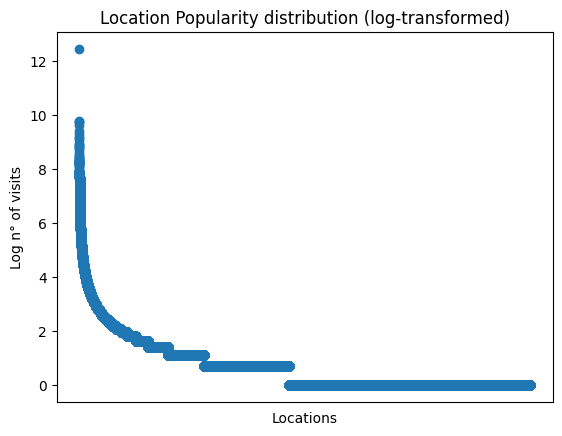

In [47]:
plt.scatter(by_popularity.index, np.log(by_popularity['n_visits'].values))
plt.title('Location Popularity distribution (log-transformed)')
plt.xticks([])
plt.xlabel('Locations')
plt.ylabel('Log n° of visits')
plt.show()

## Computing entropy

In [48]:
entropy = collective.uncorrelated_location_entropy(tdf, normalize=False, show_progress=True)

100%|████████████████████████████████████████████████████████████████████████| 693362/693362 [08:07<00:00, 1420.94it/s]


In [49]:
entropy.head()

,lat,lng,uncorrelated_location_entropy
0,-163.193333,-18.060833,0.000000
1,-122.418266,37.771596,0.000000
2,-94.578567,39.099727,0.000000
3,-90.000000,0.000000,1.519383
4,-89.999000,179.999000,0.000000


In [50]:
entropy[entropy['uncorrelated_location_entropy'] != 0.0].head()

,lat,lng,uncorrelated_location_entropy
3,-90.000000,0.000000,1.519383
18,-80.193659,25.774266,0.693147
24,-75.250973,-0.071389,1.517860
28,-64.530000,137.860000,0.636514
31,-54.800000,-68.300000,1.051204


In [51]:
locations_bylatlng = pd.DataFrame([[x] for x in list(zip(tdf['lat'], tdf['lng']))])[0].unique()
assert len(locations_bylatlng) == len(entropy), 'The records of locations should be the same'

## Plotting the distribution of Entropy
Even in this case we have a power law as the distribution is skewed towards a small number of locations with high entropy and a small number of them with lower entropy

In [52]:
sorted_entropy = entropy.sort_values(by='uncorrelated_location_entropy', ascending=False).reset_index(drop=True)

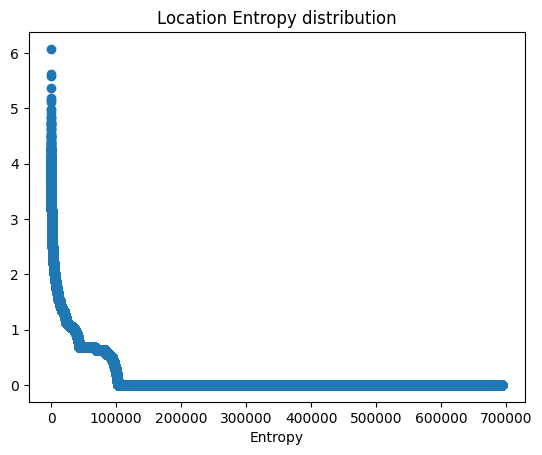

In [53]:
plt.scatter(sorted_entropy.index, sorted_entropy['uncorrelated_location_entropy'])
plt.title('Location Entropy distribution')
plt.xlabel('Locations')
plt.xlabel('Entropy')
plt.show()

The warning is just because I have some zeroes in the distribution and for those the log is not defined

C:\Users\Ludovico\AppData\Local\Temp\ipykernel_10452\1946407921.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(sorted_entropy.index, np.log(sorted_entropy['uncorrelated_location_entropy'].values))


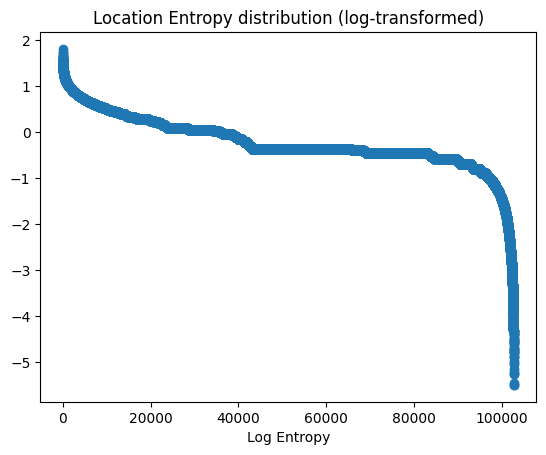

In [54]:
plt.scatter(sorted_entropy.index, np.log(sorted_entropy['uncorrelated_location_entropy'].values))
plt.title('Location Entropy distribution (log-transformed)')
plt.xlabel('Locations')
plt.xlabel('Log Entropy')
plt.show()

## Computing the correlation between Location popularity and Entropy
The spearman correlation is around 0.50, thus the entropy and the popularity of places are positively correlated again, but the correlation seems to be less relevant.

In [55]:
popularity_entropy = by_popularity.merge(entropy, on=['lat', 'lng'])[['n_visits', 'uncorrelated_location_entropy']]
popularity_entropy.head()

,n_visits,uncorrelated_location_entropy
0,256137,6.074048
1,17396,5.368545
2,16908,4.798525
3,16687,5.110701
4,15445,4.421484


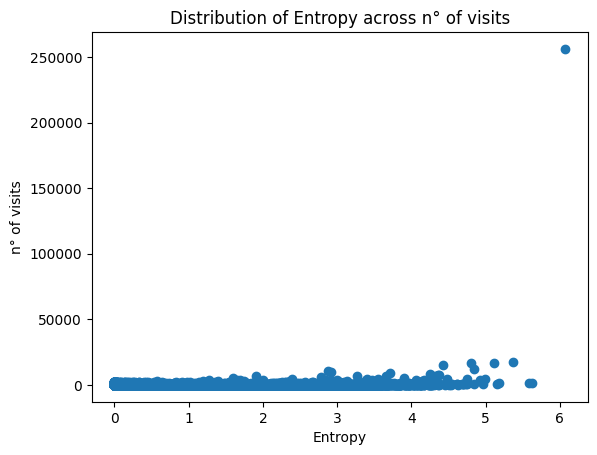

In [56]:
plt.scatter(popularity_entropy['uncorrelated_location_entropy'], popularity_entropy['n_visits'])
plt.title('Distribution of Entropy across n° of visits')
plt.xlabel('Entropy')
plt.ylabel('n° of visits')
plt.show()

Focus on the lower part of the distribution (excluding the first location with around 25,000 visits)

It seems the entropy increases with a positive correllation mostly with popular locations again, as it can be seen those seems to have a slightly larger entropy than the rest (with the most popular place having the highest entropy), but for unpopular locations it seems there is some margin of predicatibility as the entropy seems to be uncorrelated. </br></br>

<b>My guess is that in this website users recorded their daily locations more frequently with respect to the Gowalla dataset</b>

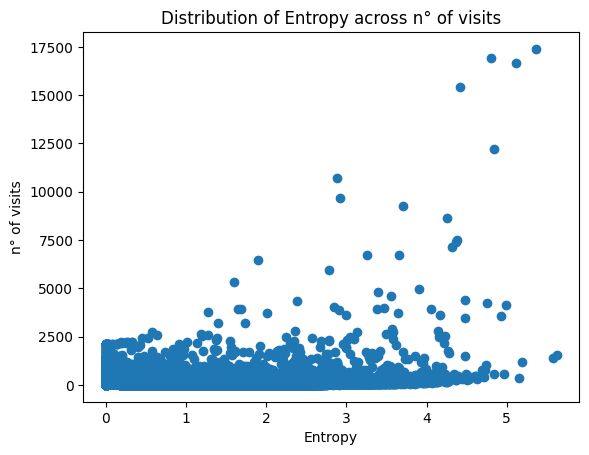

In [57]:
plt.scatter(popularity_entropy['uncorrelated_location_entropy'][1:], popularity_entropy['n_visits'][1:])
plt.title('Distribution of Entropy across n° of visits')
plt.xlabel('Entropy')
plt.ylabel('n° of visits')
plt.show()

With spearman (as pearson requires a normal distribution of the two features)

In [58]:
popularity_entropy.corr(method='spearman')

,n_visits,uncorrelated_location_entropy
n_visits,1.000000,0.527376
uncorrelated_location_entropy,0.527376,1.000000


Just checking what pearson would have returned

In [59]:
popularity_entropy.corr()

,n_visits,uncorrelated_location_entropy
n_visits,1.000000,0.053829
uncorrelated_location_entropy,0.053829,1.000000
